# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Assignment 2: MLP Regression and MLP Tuning 

## Learning Objectives

At the end of the experiment, you will be able to

- understand the concept of MLPs for regression
- know the hyperparameters of neural network and their tuning 
- understand batch normalization using Keras
- understand the concept of optimizers
- understand the time-based learning rate method through an example
- understand the different regularization methods to avoid the overfitting of neural networks

### Introduction to Regression MLPs

First, MLPs can be used for regression tasks. If we want to predict a single value (e.g., the  price  of  a  house  given  many  of  its  features), then  we  just  need  a  single  output neuron:  its  output  is  the  predicted  value.  For  multivariate  regression  (i.e.,  to  predict multiple  values  at  once),  we  need  one  output  neuron  per  output  dimension.  For example, to locate the center of an object on an image, we need to predict 2D coordinates,  so  we  need  two  output  neurons.  If  we  also  want  to  place  a  bounding  box around the object, then we need two more numbers: the width and the height of the object. So we end up with 4 output neurons.

In general, when building an MLP for regression, we do not want to use any activation  function  for  the  output  neurons,  so  they  are  free  to  output  any  range  of  values. However,  if  we  want  to  guarantee  that  the  output  will  always  be  positive,  then  we can use the ReLU activation function or the softplus activation function in the output layer.  Finally,  if  we  want  to  guarantee  that  the  predictions  will  fall  within  a  given range of values, then we can use the logistic function or the hyperbolic tangent and scale the labels to the appropriate range: 0 to 1 for the logistic function, or –1 to 1 for the hyperbolic tangent.

The loss function to use during training is typically the mean squared error, but if we have  a  lot  of  outliers  in  the  training  set,  we  may  prefer  to  use  the  mean  absolute error  instead.  Alternatively,  we  can  use  the  Huber  loss,  which  is  a  combination  of both.

**Note:** The Huber loss is quadratic when the error is smaller than a threshold $δ$ (typically 1), but linear when the error is larger than $δ$. This makes it less sensitive to outliers than the mean squared error, and
it  is  often  more  precise  and  converges  faster  than  the  mean  absolute error.

To know more about Multi Layer Perceptron (MLP), click [here](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/readings/L05%20Multilayer%20Perceptrons.pdf).

**Implementation Using Keras**

Keras is a high-level Deep Learning API that allows us to easily build train, evaluate and execute all sorts of neural networks. To know more about the documentation of Keras, click [here](https://keras.io/).

**Implementation of MLP regression Using sklearn**

The very popular machine learning library Scikit-Learn is also capable of basic deep learning modeling.

Salient points of Multilayer Perceptron (MLP) in Scikit-learn:

* There is no activation function in the output layer.
* For regression scenarios, the square error is the loss function, and cross-entropy is the loss function for the classification
* It can work with single as well as multiple target values regression.
* Unlike other popular packages, likes Keras the implementation of MLP in Scikit doesn’t support GPU.

To know more about Scikit-Learn MLP regressor, click [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html).
 

### Typical MLP Regressor Architecture


Hyperparameter             | Typical Value 
---------------------------|------------------
# input neurons            | One per input feature (e.g., 28 x 28 = 784 for MNIST)
# hidden layers            | Depends on the problem. Typically 1 to 5. 
# neurons per hidden layer | Depends on the problem. Typically 10 to 100.
# output neurons           | 1 per prediction dimension
Hidden activation          | ReLU
Output activation          | None or ReLU/Softplus (if positive outputs) or Logistic/Tanh (if bounded outputs)
Loss function              | MSE or MAE/Huber (if outliers)

### Setup Steps:

### Import required packages

In [4]:
# install livelossplot package to visualize epoch by epoch loss and accuracy curve
!pip -qq install livelossplot

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error             
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler              # scaling functions from sklearn
from sklearn.model_selection import RandomizedSearchCV, train_test_split                  # search on hyperparameters
from functools import partial                                                             # partial functions
import tensorflow as tf                                                                   # importing tensorflow library
from tensorflow import keras                                                              # importing keras package
from scipy.stats import reciprocal 
from sklearn.neural_network import MLPRegressor                                           # importing MLP regressor            
from tensorflow.keras.optimizers import SGD                                               # stochastic Gradient Descent
from tensorflow.keras.utils import to_categorical                                         # converting a class to categorical data type
from keras.datasets import mnist                                                          # load mnist dataset
import livelossplot                                                                       # visualize loss and accuracy 
from keras.models import Sequential                                                       # using keras importing Sequential Model
from keras.layers import Activation, Dense, Input, Flatten, Dropout, BatchNormalization   # using keras importing layers                                    
from keras.callbacks import EarlyStopping                                                 # to stop the training process

### Building a Regression MLP 

Here, in this implementation, we will be using California housing problem and tackle it using a regression neural network.

#### Data Preparation

In [6]:
# train dataset
df_train = pd.read_csv('/content/sample_data/california_housing_train.csv')
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [7]:
# test dataset
df_test = pd.read_csv('/content/sample_data/california_housing_test.csv')
df_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0


In [8]:
# printing train dataset information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [9]:
# printing test dataset information
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           3000 non-null   float64
 1   latitude            3000 non-null   float64
 2   housing_median_age  3000 non-null   float64
 3   total_rooms         3000 non-null   float64
 4   total_bedrooms      3000 non-null   float64
 5   population          3000 non-null   float64
 6   households          3000 non-null   float64
 7   median_income       3000 non-null   float64
 8   median_house_value  3000 non-null   float64
dtypes: float64(9)
memory usage: 211.1 KB


#### Train and Test Data

In [10]:
X_train = df_train.drop('median_house_value',axis=1)
y_train = df_train['median_house_value']
X_test = df_test.drop('median_house_value',axis=1)
y_test = df_test['median_house_value']

#### Scaling Features

In [11]:
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

There are two ways to implement MLP regressor one is using keras and the other way is using Scikit-Learn. In this section, we will discuss both two ways.

#### 1. Using Keras API

Building, training, evaluating, and using a regression MLP using the Sequential API to make  predictions  is  quite  similar  to  what  we  did  for classification.  The  main  differences  are  the  fact  that  the  output  layer  has  a  single  neuron  (since  we  only  want  to predict  a  single  value)  and  uses  no  activation  function,  and  the  loss  function  is  the mean squared error. Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting:

In [12]:
# create a model with two layers
model = Sequential([
                    Dense(30, activation="relu", input_shape=X_train.shape[1:]),
                    Dense(1)
                    ])
model.compile(optimizer='adam', loss='mse')

Keras supports the early stopping of training via a callback called EarlyStopping.

This callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process.

The EarlyStopping callback is configured when instantiated via arguments.

In [13]:
# defining early stop 
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fitting the model
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400, callbacks=[early_stop])
          

Epoch 1/400
133/133 [==============================] - 1s 3ms/step - loss: 56424718336.0000 - val_loss: 55163412480.0000
Epoch 2/400
133/133 [==============================] - 0s 2ms/step - loss: 56422834176.0000 - val_loss: 55160786944.0000
Epoch 3/400
133/133 [==============================] - 0s 2ms/step - loss: 56419414016.0000 - val_loss: 55156617216.0000
Epoch 4/400
133/133 [==============================] - 0s 2ms/step - loss: 56414355456.0000 - val_loss: 55150686208.0000
Epoch 5/400
133/133 [==============================] - 0s 2ms/step - loss: 56407371776.0000 - val_loss: 55142817792.0000
Epoch 6/400
133/133 [==============================] - 0s 2ms/step - loss: 56398622720.0000 - val_loss: 55133343744.0000
Epoch 7/400
133/133 [==============================] - 0s 2ms/step - loss: 56388284416.0000 - val_loss: 55122399232.0000
Epoch 8/400
133/133 [==============================] - 0s 2ms/step - loss: 56376520704.0000 - val_loss: 55110033408.0000
Epoch 9/400
133/133 [===========

In [14]:
# Sequential Model Summary 
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                270       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


##### Prediction

In [15]:
y_pred = model.predict(X_test)
print(y_pred)

[[159875.38]
 [157673.62]
 [156410.81]
 ...
 [120362.21]
 [150875.39]
 [168447.81]]


##### Evaluation

In [16]:
np.sqrt(mean_squared_error(y_test,y_pred))

122399.06524135193

#### 2. Using Sci-kit Learn API

Using the same dataset, we will implement MLP regressor using sci-kit learn API. 

In the below code, one hidden layer is modeled with 32 neurons. Considering
the input and output layer, we have a total of 5 layers in the model. In case any optimizer is not mentioned then “Adam” is the default optimizer and it can manage a pretty large dataset.

In [17]:
# implementing MLPregressor
regr = MLPRegressor(hidden_layer_sizes=(32), activation="relu", random_state=1, max_iter=500).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


##### Prediction

In [18]:
y_pred = regr.predict(X_test)
print(y_pred)

[106943.7296704  105433.71377299 104575.22478819 ...  80490.94502437
 100875.35533722 112639.58639599]


##### Evaluation

In [19]:
np.sqrt(mean_squared_error(y_test,y_pred))

152367.3177159458

Now, let us look at the tuning of the neural network hyperparameters or hyperparameter regularization.

### Fine-Tuning Neural Network Hyperparameters

The flexibility of neural networks is also one of their main drawbacks: there are many hyperparameters  to  tweak.  Not  only  can  we  use  any  imaginable  network  architecture, but even in a simple MLP we can change the number of layers, the number of neurons per layer, the type of activation function to use in each layer, the weight initialization  logic,  and  much  more. 

One  option  is  to  simply  try  many  combinations  of  hyperparameters  and  see  which one works best on the validation set (or using K-fold cross-validation). For this, one approach  is  simply to use  GridSearchCV  or  RandomizedSearchCV  to  explore  the  hyperparameter space.

The first step is to create a function that will build and compile a Keras model, given a set of hyperparameters:

In [20]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(Dense(1, **options))
    optimizer = SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

This function creates a simple Sequential model for univariate regression (only one output  neuron),  with  the  given  input  shape  and  the  given  number  of  hidden  layers and  neurons,  and  it  compiles  it  using  an  SGD  optimizer  configured  with  the  given learning rate.

Next, let’s create a KerasRegressor based on this build_model() function:

In [21]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


We want to train hundreds of variants and see which one performs best on the validation set. Since there are many hyperparameters, it is preferable to use a randomized search rather than grid search. 

Let’s try to explore the number of hidden layers, the number of neurons, and the learning rate:

In [22]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

In [23]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_test,y_test.values),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])   

Epoch 1/100
355/355 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 2/100
355/355 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 3/100
355/355 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 4/100
355/355 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 5/100
355/355 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 6/100
355/355 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 7/100
355/355 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 8/100
355/355 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 9/100
355/355 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 10/100
178/178 [==============================] - 0s 2ms/step - loss: nan
Epoch 1/100
355/355 [==============================] - 1s 2ms/ste

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -1.35259686e+10             nan             nan
             nan -1.35367868e+10 -1.02405751e+10             nan
 -5.98901026e+09 -1.35292563e+10]
  category=UserWarning,


532/532 [==============================] - 1s 2ms/step - loss: 15270102016.0000 - val_loss: 11498108928.0000
Epoch 2/100
532/532 [==============================] - 1s 2ms/step - loss: 11527255040.0000 - val_loss: 10656107520.0000
Epoch 3/100
532/532 [==============================] - 1s 1ms/step - loss: 10696049664.0000 - val_loss: 9944542208.0000
Epoch 4/100
532/532 [==============================] - 1s 2ms/step - loss: 9991144448.0000 - val_loss: 9341755392.0000
Epoch 5/100
532/532 [==============================] - 1s 1ms/step - loss: 9392601088.0000 - val_loss: 8828051456.0000
Epoch 6/100
532/532 [==============================] - 1s 1ms/step - loss: 8881211392.0000 - val_loss: 8392013312.0000
Epoch 7/100
532/532 [==============================] - 1s 2ms/step - loss: 8445274624.0000 - val_loss: 8018186752.0000
Epoch 8/100
532/532 [==============================] - 1s 2ms/step - loss: 8072758272.0000 - val_loss: 7699978752.0000
Epoch 9/100
532/532 [==============================] - 

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f6879359c50>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6879376510>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

The above  exploration  may  last  many  hours  depending  on  the  hardware,  the  size  of  the dataset, the complexity of the model and the value of n_iter and cv. When it is over, we can access the best parameters found, the best score, and the trained Keras model like this:

In [24]:
# finding the best parameters
rnd_search_cv.best_params_

{'learning_rate': 0.004481155102807602, 'n_hidden': 0, 'n_neurons': 50}

In [26]:
# best score
rnd_search_cv.best_score_

-5989010261.333333

In [27]:
# applying best parameters to the model for predictions
model = rnd_search_cv.best_estimator_.model

Refer to the guidelines below for choosing the  number  of  hidden  layers  and  neurons  in  an  MLP,  and  selecting  appropriate  values  for some of the main hyperparameters.

#### Number of Hidden Layers

- For simple problems, we can start with just one or two hidden layers and get the accurate results.
- For more complex problems, we can gradually rampup the number of hidden layers, until we start overfitting the training set. Very complex  tasks,  such  as  large  image  classification  or  speech  recognition,  typically  require networks  with  dozens  of  layers  (or  even  hundreds,  but  not  fully  connected  ones),  and  they  need  a  huge  amount  of  training  data. 

#### Number of Neurons per Hidden Layer

- We can try increasing the number of neurons gradually  until  the  network  starts  overfitting. 
- In general, it may be more advantageous to increase  the  number  of  layers  than  the  number  of  neurons  per  layer.
- A  simpler  approach  is  to  pick  a  model  with  more  layers  and  neurons  than  we actually need, then use early stopping to prevent it from overfitting (and other regularization  techniques,  such  as  dropout, which we will discuss further in this notebook).

#### Learning Rate, Batch Size, and Other Hyperparameters

Here are some of the important hyperparameters other than hidden layers and neurons, and some tips on how to set them:

- The learning rate is arguably the most important hyperparameter. In general, the optimal learning rate is about half of the maximum learning rate (i.e., the learning rate above which the training algorithm diverges). So a  simple  approach  for  tuning  the  learning  rate  is  to  start  with  a  large  value  that makes  the  training  algorithm  diverge,  then  divide  this  value  by  3  and  try  again, and repeat until the training algorithm stops diverging.
- Choosing  a  better  optimizer  than  plain  old  Mini-batch  Gradient  Descent  (and tuning its hyperparameters) is also quite important. We will discuss this in further sections.
- The  batch  size  can  also  have  a  significant  impact  on  our  model’s  performance and the training time. In general the optimal batch size will be lower than 32. We will study batch normalization further in this notebook.
- We discussed the choice of the activation function in previous assignment notebook, the $ReLU$ activation function will be a good default for all hidden layers. For the output layer, it really depends on our task.
- In  most  cases,  the  number  of  training  iterations  does  not actually  need  to  be tweaked: just use early stopping instead.

Let us also take a look at techniques such as Batch normalization, overfitting, drop out, optimizers and learning rate to  train deep neural networks.

To know more about hyperparameter tuning of deep neural networks, click [here](https://towardsdatascience.com/the-art-of-hyperparameter-tuning-in-deep-neural-nets-by-example-685cb5429a38).

### Accelerate Learning of Deep Neural Networks With Batch Normalization

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

![Image](https://lh3.googleusercontent.com/-9hMD_jyPLuE/YNQoKrc-_4I/AAAAAAAACTs/9nZ-BEdtI-QoAe6R5HXlG6X3AcprX8NaQCJEEGAsYHg/s512/2021-06-23.png)

$\text{Figure: Batch Normalization Algorithm}$

So  during  training,  BN  just  standardizes  its  inputs  then  rescales  and  offsets  them.

#### Implementing Batch Normalization with Keras

Implementing  Batch  Normalization  is  quite  simple, just  add  a  BatchNormalization  layer  before  or  after  each  hidden  layer’s  activation function,  and  optionally  add  a  BN  layer  as  well  as  the  first  layer  in  our  model.  For example,  this  model  applies  BN  after  every  hidden  layer  and  as  the  first  layer  in  the
model (after flattening the input images):

In [30]:
# create model with Batch Normalization
model = Sequential([
                    Flatten(input_shape=[28, 28]),
                    BatchNormalization(),
                    Dense(300, activation="relu", kernel_initializer="he_normal"),
                    BatchNormalization(),
                    Dense(100, activation="relu", kernel_initializer="he_normal"),
                    BatchNormalization(),
                    Dense(10,activation="softmax")
                    ])

If we display the model summary, we can see that each BN layer adds 4 parameters per input: γ, β, μ and σ (for example, the first BN layer adds 3136 parameters, which is 4 times 784). The last two parameters, μ and σ, are the moving averages, they are not affected by backpropagation, so Keras calls them “Nontrainable” (if we count the total number of BN parameters, 3136 + 1200 + 400, and divide  by  two,  we get  2,368,  which  is  the  total  number  of  non-trainable  params  in this model).

In [31]:
# summary of model
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_69 (Dense)            (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_70 (Dense)            (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)            

Let’s look at the parameters of the first BN layer. Two are trainable (by backprop), and two are not:

In [32]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [33]:
model.layers[1].updates

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  """Entry point for launching an IPython kernel.


[]

Moreover,  since  a  Batch  Normalization layer includes one offset parameter per input, we can remove the bias term from the previous layer (just pass `use_bias=False` when creating it).

In [35]:
# create model
model = Sequential([
                    BatchNormalization(),
                    Dense(300, kernel_initializer="he_normal", use_bias=False),
                    BatchNormalization(),
                    Activation("relu"),
                    Dense(100, kernel_initializer="he_normal", use_bias=False),
                    Activation("relu"),
                    BatchNormalization(),
                    Dense(10,activation="softmax")
                    ])

The  BatchNormalization class has regularizable hyperparameters. Tweaking the “momentum” argument allows us to control how much of the statistics from the previous mini batch to include when the update is calculated.


A good momentum value is typically close to 1, for example, 0.9, 0.99, or 0.999 

To know more about batch normalization, click [here](https://towardsdatascience.com/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f).

###  Optimizers

Some popular optimizers used for boosting the speed in training large deep neural networks are: Momentum optimization, RMSProp, and Adam optimization. Refer [here](https://mlfromscratch.com/optimizers-explained/#/) for a detailed understanding.

#### Momentum Optimization

Momentum  optimization subtracts  the  local  gradient  from  the  momentum  vector  m  (multiplied  by  the  learning  rate  η),  and  it  updates  the  weights  by  simply  adding  this momentum vector, thus accelerating the speed. The momentum hyperparameter $β$ is introduced to prevent  the momentum from growing too large (set between 0 and 1, typically 0.9).



In [37]:
#Implementing the momentum optimizer
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

#### RMSProp

The RMSProp algorithm fixes only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step. 

The decay rate $β$ is typically set to 0.9. Yes, it is once again a new hyperparameter, but this default value often works well, so we may not need to tune it at all.


In [38]:
#Implementing the RMSProp optimizer
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


#### Adam Optimization

Adam combines the ideas of Momentum  optimization  and  RMSProp:  it keeps track of both, an  exponentially  decaying  average  of  past  gradients,  and  an  exponentially  decaying  average  of  past  squared  gradients.

The momentum decay hyperparameter $β_1$ is typically initialized to 0.9, while the scaling  decay  hyperparameter  $β_2$  is  often  initialized  to  0.999.

In [39]:
#Implementing the Adam optimizer
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


To know more about optimizers, click [here](https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6#:~:text=Optimizers%20are%20algorithms%20or%20methods,help%20to%20get%20results%20faster).

#### Learning Rate Schedule For Training Models

The simplest adaptation of learning rate during training are techniques that reduce the learning rate over time. These have the benefit of making large changes at the beginning of the training procedure when larger learning rate values are used, and decreasing the learning rate such that a smaller rate and therefore smaller training updates are made to weights later in the training procedure.

##### Time-Based Learning Rate Scheduling

Keras has an in-built time-based learning rate schedule function.

The decay argument in the stochastic gradient descent optimization algorithm  is used in the time-based learning rate decay schedule equation as follows:

- LearningRate = LearningRate * $\frac{1}{(1 + decay * epoch)}$

When the decay argument is zero (the default), this has no effect on the learning rate.

- LearningRate = 0.1 * $\frac{1}{(1 + 0.0 * 1)} \implies $LearningRate = 0.1

When the decay argument is specified, it will decrease the learning rate from the previous epoch by the given fixed amount.

*See the implementation of time-based learning rate scheduling with the MNIST dataset Example at the end of this notebook.*

### Regularization

Deep neural networks may have millions of parameters. The network, therefore,   has vast freedom and can fit a huge variety of complex datasets. This flexibility however also makes it prone to overfitting the training set. Thus we need regularization.

Let us now see some popular regularization techniques for neural networks: $ℓ1$ and $ℓ2$ regularization and dropout

#### $ℓ1$ and $ℓ2$ Regularization

We can use $ℓ1$ and $ℓ2$ regularization  to  constrain  a  neural  network’s  connection  weights  (but  typically  not  its  biases).  Here  is  how  to  apply  $ℓ2$  regularization  to  a  Keras  layer’s  connection  weights, using a regularization factor of 0.01:

In [40]:
layer = Dense(100, activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

Applying the  same  regularizer, activation function and initialization strategy repeatedly to  all  layers  in  our  network may make it error-prone. To avoid this, we can try refactoring our code to use loops. Another option is to use Python’s `functools.partial()` function: it lets us  create  a  thin  wrapper  for  any  callable,  with  some  default  argument  values.  For example:

In [41]:
# creating regularized dense layer for model
RegularizedDense = partial(keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [43]:
# defining model with regularization
model = Sequential([
    Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax",
                     kernel_initializer="glorot_uniform")
])

#### Dropout

Dropout  is  one  of  the  most  popular  regularization  techniques  for  deep  neural  networks. At each training stage, individual nodes are either dropped out of the net with probability 1-p or kept with probability p, so that a reduced network is left; incoming and outgoing edges to a dropped-out node are also removed.

![Image](https://i.ibb.co/HnfSTyX/M5-2.jpg)

$\text{Figure: Dropout Regularization}$

To  implement  dropout  using  Keras,  we  can  use  the  keras.layers.Dropout  layer. During  training,  it  randomly  drops  some  inputs  (setting  them  to  0)  and  divides  the remaining inputs by the keep probability. After training, it just passes  the  inputs  to  the  next  layer.  For  example,  the  following  code  applies  dropout regularization before every Dense layer, using a dropout rate of 0.2:

In [45]:
model = Sequential([
                    Flatten(input_shape=[28, 28]),
                    Dropout(rate=0.2),
                    Dense(300, activation="relu", kernel_initializer="he_normal"),
                    Dropout(rate=0.2),
                    Dense(100, activation="relu", kernel_initializer="he_normal"),
                    Dropout(rate=0.2),
                    Dense(10,activation="softmax")
                    ])

If we observe that the model is overfitting, we can increase the dropout rate. Conversely, we should try decreasing the dropout rate if the model underfits the training set. 

Based on the learnings above, let us now explore hyperparameter tuning during the neural network training phase.

Here, we implement the sequential model and use the **MNIST dataset**.

#### Data Preparation

We load the MNIST dataset, using Keras' dataset utilities.

In [46]:
# data resizing variables
NUM_ROWS = 28
NUM_COLS = 28
NUM_CLASSES = 10

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


To feed MNIST instances into a neural network, they need to be reshaped, from a 2D image representation to a single dimension sequence. We also convert the class vector to a binary matrix (using to_categorical). This is accomplished below after which the same function defined above is called again in order to show the effects of our data reshaping.

In [47]:
# Reshape data
X_train = X_train.reshape((X_train.shape[0], NUM_ROWS * NUM_COLS))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], NUM_ROWS * NUM_COLS))
X_test = X_test.astype('float32') / 255

# Categorically encode labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [48]:
# create the sequential model with BN and dropout layers
model = Sequential([
    Dense(300, kernel_initializer="he_normal", use_bias=False),
    # dropout layer to drop neurons with rate less than 0.2
    Dropout(rate=0.2),
    # BN layer to rescale the inputs
    BatchNormalization(),
    Activation("relu"),
    Dense(100, kernel_initializer="he_normal", use_bias=False),
    Dropout(rate=0.2),
    Activation("relu"),
    BatchNormalization(),
    Dense(10, activation="softmax")
])

**Note:** You can also try to define Regularized dense layer and can create a sequential model as we see in the $l1$ and $l2$ regularization section discussed above.

In [50]:
# time based learning-rate scheduling
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
# define optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, decay=decay_rate)
 
# Compile model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

**Note:** In the above code cell, you can also try compiling the with other optimizers like RMS prop, momentum optimization, etc.

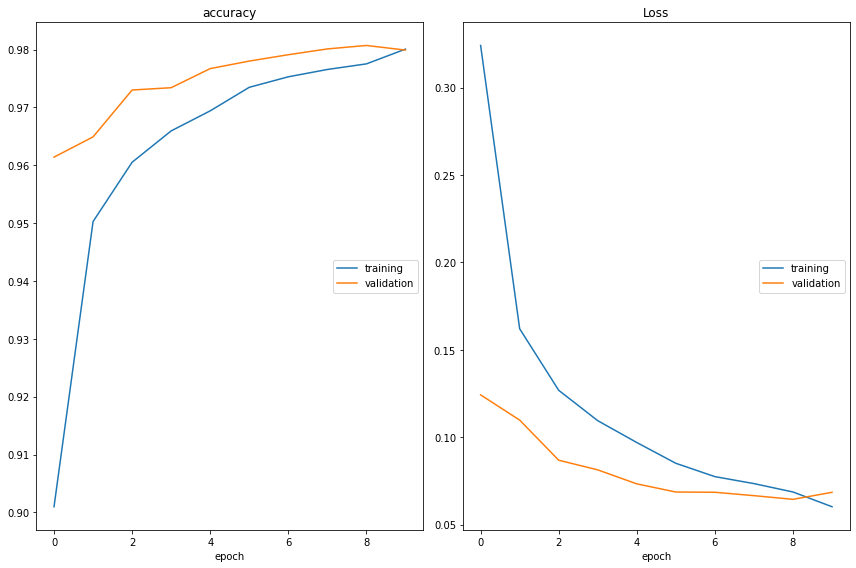

accuracy
	training         	 (min:    0.901, max:    0.980, cur:    0.980)
	validation       	 (min:    0.961, max:    0.981, cur:    0.980)
Loss
	training         	 (min:    0.060, max:    0.324, cur:    0.060)
	validation       	 (min:    0.064, max:    0.124, cur:    0.068)
469/469 [==============================] - 5s 10ms/step - loss: 0.0602 - accuracy: 0.9801 - val_loss: 0.0685 - val_accuracy: 0.9799


In [51]:
# outputs epoch-by-epoch loss functions and accuracies at the end of each epoch of training
plot_losses = livelossplot.PlotLossesKeras()

# Train model
model.fit(X_train, y_train,
          batch_size=128,
          epochs=epochs,
          callbacks=[plot_losses],
          verbose=1,
          validation_data=(X_test, y_test))


##### Evaluation

In [52]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06846323609352112
Test accuracy: 0.9799000024795532


##### Model Summary

In [53]:
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 300)               235200    
                                                                 
 dropout_3 (Dropout)         (None, 300)               0         
                                                                 
 batch_normalization_9 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 300)               0         
                                                                 
 dense_85 (Dense)            (None, 100)               30000     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                     

### Theory Questions

**Q1.** How many neurons do you need in the output layer if you want to classify email into spam or ham? What activation function should you use in the output layer?

**Answer 1:** Email classification is a binary classification problem, so you would only need one neuron in the output layer. This neuron would indicate the probability that the email is spam or ham. You'd most likely use the sigmoid activation function in the output layer.

For the MNIST problem you would need 10 output neurons in the final layer, one for each digit. You would then replace the logistic function with the softmax function which can output one probability per class per digit.

**Q2.** Can you list all the hyperparameters you can tweak in an MLP? If the MLP overfits the training data, how could you tweak these hyperparameters to try to solve the problem?

**Answer 2:** In general, the hyperparameters of a neural network you can adjust are the number of hidden layers, the number of neurons in each hidden layer, and the activation function used by each neuron.

For binary classification, use the logistic activation function. For a multi-class problem, use softmax. For a linear regression problem, don't use an activation function.

Some simple ways to try and solve overfitting are reducing the number of hidden layers or the number of neurons.

**Q3.** What  may  happen  if  you  set  the  momentum  hyperparameter  too  close  to  1  (e.g., 0.99999) when using an SGD optimizer?

**Answer 3:** If you set the momentum hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller momentum value.

**Q4.** Does dropout slow down training?

**Answer 4:** Yes, dropout does slow down training, in general roughly by a factor of two.